# 1. Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

# 2. Device Setup

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


# 3. Dataset Loading & Preprocessing

In [3]:
# 데이터셋 경로 설정 (사용자 환경에 맞게 수정 필요)
dataset_dir = "~/work/data_augmentation/data/Images/"

# 기본 Transform 설정
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

try:
    # 데이터셋 로드
    full_dataset = ImageFolder(root=dataset_dir, transform=transform)
    
    # Train/Test Split
    total_size = len(full_dataset)
    train_size = int(0.8 * total_size)
    test_size = total_size - train_size
    ds_train, ds_test = random_split(full_dataset, [train_size, test_size])

    ds_info = {
        "num_classes": len(full_dataset.classes),
        "class_names": full_dataset.classes
    }
    print(f"Classes: {ds_info['num_classes']}, Train: {len(ds_train)}, Test: {len(ds_test)}")
    
except Exception as e:
    print(f"데이터셋 로드 실패 (경로 확인 필요): {e}")
    # 더미 데이터 (실행 테스트용)
    ds_info = {"num_classes": 120, "class_names": [str(i) for i in range(120)]}

Classes: 120, Train: 16463, Test: 4116


# 4. Helper Functions: Transforms & Mixup

In [4]:
def get_transforms(with_aug=False):
    """Augmentation 여부에 따른 Transform 반환"""
    base_transforms = [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]
    
    if with_aug:
        aug_transforms = [
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2),
        ]
        return transforms.Compose(aug_transforms + base_transforms)
    
    return transforms.Compose(base_transforms)

def apply_normalize_on_dataset(dataset, is_test=False, batch_size=32, with_aug=False):
    """DataLoader 생성 함수"""
    # Transform 적용
    final_transform = get_transforms(with_aug=with_aug and not is_test)

    # Subset인 경우 원본 데이터셋의 transform 속성을 잠시 변경하여 적용하는 방식
    # (주의: 실제 운영 환경에서는 Subset에 별도 Transform을 래핑하는 것이 더 안전함)
    if hasattr(dataset, 'dataset'):
        dataset.dataset.transform = final_transform
    else:
        dataset.transform = final_transform

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=not is_test,
        num_workers=2,
        pin_memory=True
    )
    return dataloader

def mixup(x, y, alpha=1.0):
    """Mixup Augmentation 함수"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index]
    mixed_y = lam * y + (1 - lam) * y[index]

    return mixed_x, mixed_y

def mixup_loss(pred, target):
    """Mixup 적용 시 사용하는 Loss (target은 one-hot 형태여야 함)"""
    log_prob = F.log_softmax(pred, dim=1)
    loss = -torch.sum(target * log_prob, dim=1)
    return loss.mean()

In [5]:
# DataLoader 생성
train_loader = apply_normalize_on_dataset(ds_train, is_test=False, batch_size=32, with_aug=True)
val_loader = apply_normalize_on_dataset(ds_test, is_test=True, batch_size=32)

# 5. Model Definition (ResNet18)

In [6]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=120):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64,  num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_channels, out_channels, s))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def ResNet18(num_classes=120):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

# 모델 초기화
model = ResNet18(num_classes=ds_info["num_classes"]).to(device)

# 6. Training & Validation Setup

In [7]:
# Optimizer, Scheduler, Loss
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, loader, optimizer, num_classes, use_mixup=False, mixup_alpha=1.0):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        if use_mixup:
            # Mixup 적용을 위해 Label을 One-hot으로 변환
            labels_onehot = F.one_hot(labels, num_classes=num_classes).float()
            images, labels_mixed = mixup(images, labels_onehot, alpha=mixup_alpha)
            
            outputs = model(images)
            loss = mixup_loss(outputs, labels_mixed)
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
        # 정확도 계산 (Mixup 사용 시 argmax로 예측)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += images.size(0)

    return total_loss / len(loader), correct / total

@torch.no_grad()
def validate(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += images.size(0)

    return total_loss / len(loader), correct / total

# 7. Start Training

In [8]:
num_epochs = 10
num_classes = ds_info["num_classes"]

print("Start Training...")
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(
        model, 
        train_loader, 
        optimizer, 
        num_classes=num_classes,
        use_mixup=True, 
        mixup_alpha=0.4
    )
    
    val_loss, val_acc = validate(model, val_loader)

    scheduler.step()

    print(
        f"[Epoch {epoch+1}/{num_epochs}] "
        f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
        f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
    )

Start Training...
[Epoch 1/10] Train Loss: 4.7581 | Train Acc: 0.0143 Val Loss: 4.8712 | Val Acc: 0.0245
[Epoch 2/10] Train Loss: 4.5545 | Train Acc: 0.0220 Val Loss: 4.6043 | Val Acc: 0.0296
[Epoch 3/10] Train Loss: 4.4315 | Train Acc: 0.0295 Val Loss: 4.2928 | Val Acc: 0.0510
[Epoch 4/10] Train Loss: 4.3041 | Train Acc: 0.0391 Val Loss: 4.1094 | Val Acc: 0.0709
[Epoch 5/10] Train Loss: 4.1888 | Train Acc: 0.0482 Val Loss: 4.4253 | Val Acc: 0.0651
[Epoch 6/10] Train Loss: 4.0882 | Train Acc: 0.0550 Val Loss: 3.9545 | Val Acc: 0.0889
[Epoch 7/10] Train Loss: 4.0044 | Train Acc: 0.0648 Val Loss: 3.9859 | Val Acc: 0.0957
[Epoch 8/10] Train Loss: 3.9036 | Train Acc: 0.0832 Val Loss: 3.8948 | Val Acc: 0.1402
[Epoch 9/10] Train Loss: 3.7812 | Train Acc: 0.0892 Val Loss: 3.6610 | Val Acc: 0.1356
[Epoch 10/10] Train Loss: 3.6676 | Train Acc: 0.1028 Val Loss: 3.6259 | Val Acc: 0.1429


In [9]:
torch.save(model.state_dict(), "resnet18_mixup.pth")
print("Model saved successfully!")

Model saved successfully!


In [10]:
num_epochs = 10
num_classes = ds_info["num_classes"]

# 기록 저장을 위한 리스트 선언
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

print("Start Training...")
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(
        model, 
        train_loader, 
        optimizer, 
        num_classes=num_classes,
        use_mixup=True, 
        mixup_alpha=0.4
    )
    
    val_loss, val_acc = validate(model, val_loader)

    scheduler.step()

    # 기록 저장
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(
        f"[Epoch {epoch+1}/{num_epochs}] "
        f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
        f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
    )

Start Training...
[Epoch 1/10] Train Loss: 3.3150 | Train Acc: 0.1515 Val Loss: 2.9933 | Val Acc: 0.2500
[Epoch 2/10] Train Loss: 3.1950 | Train Acc: 0.1700 Val Loss: 2.9521 | Val Acc: 0.2592
[Epoch 3/10] Train Loss: 3.0834 | Train Acc: 0.1863 Val Loss: 2.8959 | Val Acc: 0.2736
[Epoch 4/10] Train Loss: 3.0512 | Train Acc: 0.1914 Val Loss: 2.8836 | Val Acc: 0.2738
[Epoch 5/10] Train Loss: 2.9159 | Train Acc: 0.2082 Val Loss: 2.8075 | Val Acc: 0.2886
[Epoch 6/10] Train Loss: 2.8060 | Train Acc: 0.2215 Val Loss: 2.7800 | Val Acc: 0.2937
[Epoch 7/10] Train Loss: 2.7570 | Train Acc: 0.2353 Val Loss: 2.8024 | Val Acc: 0.2925
[Epoch 8/10] Train Loss: 2.6448 | Train Acc: 0.2571 Val Loss: 2.8122 | Val Acc: 0.2918
[Epoch 9/10] Train Loss: 2.4894 | Train Acc: 0.3132 Val Loss: 2.7900 | Val Acc: 0.3027
[Epoch 10/10] Train Loss: 2.3959 | Train Acc: 0.3351 Val Loss: 2.9387 | Val Acc: 0.2711


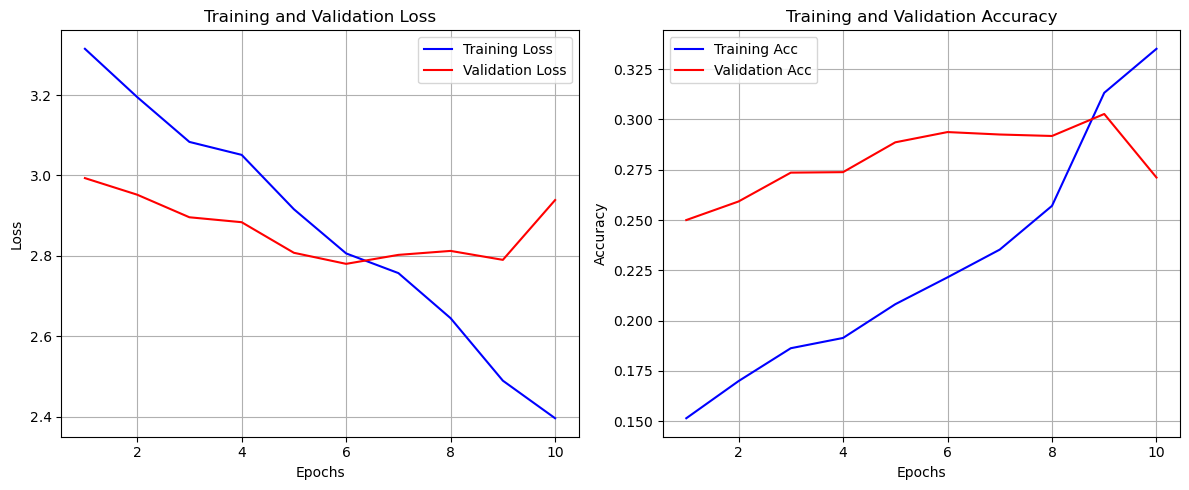

In [11]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Training Acc')
    plt.plot(epochs, history['val_acc'], 'r-', label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# 그래프 그리기
plot_history(history)